In [1]:
import sys
import math

from PIL import Image

import numpy as np
from bisect import bisect_left

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import cm

# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D

from pprint import pprint
from random import random
from math import floor, sqrt, sin, cos, acos, log, exp, pi

In [2]:
# HSV values in [0..1[
# returns [r, g, b] values from 0 to 255
# https://martin.ankerl.com/2009/12/09/how-to-create-random-colors-programmatically/
def hsv_to_rgb(h, s, v):
    h_i = int(h * 6)
    f = h * 6 - h_i
    p = v * (1 - s)
    q = v * (1 - f * s)
    t = v * (1 - (1 - f) * s)
    if h_i == 0: r, g, b = v, t, p
    elif h_i == 1: r, g, b = q, v, p
    elif h_i == 2: r, g, b = p, v, t
    elif h_i == 3: r, g, b = p, q, v
    elif h_i == 4: r, g, b = t, p, v
    elif h_i == 5: r, g, b = v, p, q
    return int(r*256), int(g*256), int(b*256)

In [3]:
# https://blog.bruce-hill.com/hill-noise
# https://www.redblobgames.com/articles/noise/2d/

copyright = """
Copyright (c) 2021 Bruce Hill

"Commons Clause" License Condition v1.0

The Software is provided to you by the Licensor under the License, as defined
below, subject to the following condition.

Without limiting other conditions in the License, the grant of rights under the
License will not include, and the License does not grant to you, the right to
Sell the Software.

For purposes of the foregoing, "Sell" means practicing any or all of the rights
granted to you under the License to provide to third parties, for a fee or
other consideration (including without limitation fees for hosting or
consulting/ support services related to the Software), a product or service
whose value derives, entirely or substantially, from the functionality of the
Software. Any license notice or attribution required by the License must also
include this Commons Clause License Condition notice.

Software: bruce-hill.com
License: MIT
Licensor: Bruce Hill

Permission is hereby granted, free of charge, to any person obtaining a copy of
this software and associated documentation files (the "Software"), to deal in
the Software without restriction, including without limitation the rights to
use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies
of the Software, and to permit persons to whom the Software is furnished to do
so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
"""

In [4]:
class ValueNoise:
    NUM_VALUES = 256
    SPACING = 10
    def __init__(self, random=random):
        self.values = [random() for _ in range(ValueNoise.NUM_VALUES)]
    def evaluate(self, x):
        # Look up the nearest two values
        x1 = floor(x/ValueNoise.SPACING)
        x2 = ceil(x/ValueNoise.SPACING)
        n1 = self.values[x1 % ValueNoise.NUM_VALUES]
        n2 = self.values[x2 % ValueNoise.NUM_VALUES]
        # Smoothly interpolate between them using cosine interpolation
        k = .5 - .5*cos((x/ValueNoise.SPACING % 1)*pi)
        return ((1-k)*n1 + k*n2)

In [5]:
class OctaveNoise:
    def __init__(self, num_octaves, random=random):
        self.noise = ValueNoise(random=random)
        self.num_octaves = num_octaves
    def evaluate(self, x):
        noise = 0
        for i in range(self.num_octaves):
            size = 0.5**i
            noise += size * self.noise.evaluate(x/size)
        return noise/2

In [6]:
class HillNoise:
    def __init__(self, sizes, random=random):
        self.sizes = sizes
        self.offsets = [random()*2*pi for _ in range(len(sizes))]
        self.sigma = sqrt(sum((a/2)**2 for a in self.sizes))
    def evaluate(self, x):
        noise = 0
        for size,offset in zip(self.sizes, self.offsets):
            noise += size*sin(x/size + offset)
        # Approximate normal CDF:
        noise /= self.sigma
        return (0.5*(-1 if noise < 0 else 1) * sqrt(1 - exp(-2/pi * noise*noise)) + 0.5)

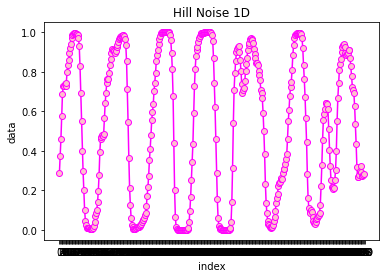

In [7]:
hn1d = HillNoise([random() for _ in range(32)])

data = [hn1d.evaluate(i/10) for i in range(0, 400)]

plt.plot(data, color='magenta', marker='o',mfc='pink' )
plt.xticks(range(0,len(data)+1, 1))

plt.ylabel('data')
plt.xlabel('index')
plt.title("Hill Noise 1D")
plt.show()

In [8]:
class WeibullHillNoise:
    def __init__(self, sizes, alpha, beta, random=random):
        self.hill_noise = HillNoise(sizes, random)
        self.alpha, self.beta = alpha, beta
    def evaluate(self, x):
        u = 1.0 - self.hill_noise.evaluate(x)
        return self.alpha * (-math.log(u)) ** (1.0/self.beta)

In [9]:
# https://blog.bruce-hill.com/media/hill-noise/hill_noise_2dshader.html
GOLDEN_RATIO = (sqrt(5)+1)/2
class HillNoise2D:
    def __init__(self, sizes, random=random):
        self.sizes = sizes
        self.offsets = [random()*2*pi for _ in range(2*len(sizes))]
        self.sigma = sqrt(sum((a/2)**2 for a in self.sizes))
    def evaluate(self, x, y):
        noise = 0
        for i,size in enumerate(self.sizes):
            # Rotate coordinates
            rotation = (i*GOLDEN_RATIO % 1)*2*pi
            u = x*cos(rotation) - y*sin(rotation)
            v = -x*sin(rotation) - y*cos(rotation)
            noise += size/2*(sin(u/size + self.offsets[2*i])
                             + sin(v/size + self.offsets[2*i+1]))
        # Approximate normal CDF:
        noise /= 2*self.sigma
        return (0.5*(-1 if noise < 0 else 1) * sqrt(1 - exp(-2/pi * noise*noise)) + 0.5)

In [10]:
hn3d = HillNoise2D([random() for _ in range(10)])
hn3d.evaluate(1,2)

0.6214127999344464

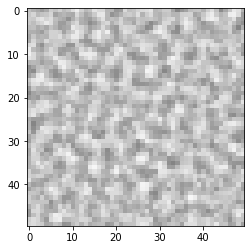

In [11]:
hn2d = HillNoise2D([random() for _ in range(32)])

img_w = 50
img_h = 50

img = Image.new('RGBA', (img_w, img_h), (0, 0, 0, 0))
pixels = img.load()

for x in range(img_w):
    for y in range(img_h):
        h = hn2d.evaluate(x, y) * 127 + 128
        r = h
        g = h
        b = h
        pixels[x, y] = ( int(r), int(g), int(b), int(255) )

plt.imshow(img)
plt.show()

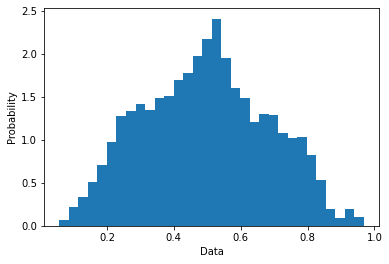

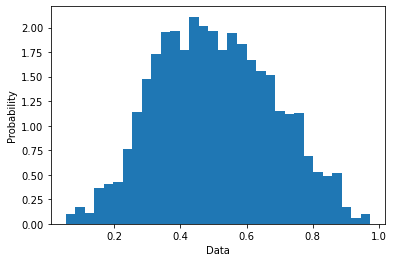

In [12]:
v = [ hn2d.evaluate(x/10, 0) for x in range(0, 5000) ]

plt.hist(v, density=True, bins=32)
plt.ylabel('Probability')
plt.xlabel('Data')
plt.show()

v = [ hn2d.evaluate(0, y/10) for y in range(0, 5000) ]

plt.hist(v, density=True, bins=32)
plt.ylabel('Probability')
plt.xlabel('Data')
plt.show()

In [13]:
# https://blog.bruce-hill.com/media/hill-noise/hill_noise_3dshader.html
# https://www.graphics.rwth-aachen.de/media/papers/jgt.pdf
GOLDEN_RATIO = (sqrt(5)+1)/2
class HillNoise3D:
    def __init__(self, sizes, random=random):
        self.sizes = sizes
        self.offsets = [random()*2*pi for _ in range(3*len(sizes))]
        self.sigma = sqrt(sum((a/2)**2 for a in self.sizes))
    def evaluate(self, x, y, z):
        resolution = len(self.sizes)
        # Find the biggest fibonacci number fib_num such that fib_num < resolution
        fib_num = floor(log((resolution-1)*sqrt(5) + .5)/log(GOLDEN_RATIO))
        dec = floor(.5 + (GOLDEN_RATIO**fib_num)/sqrt(5))
        inc = floor(.5 + dec/GOLDEN_RATIO)
        noise = 0
        j = 0
        for i in range(len(self.sizes)):
            if j >= dec:
                j -= dec
            else:
                j += inc
                if j >= len(self.sizes):
                    j -= dec
            # Convert golden ratio sequence into polar coordinate unit vector
            phi = ((i*GOLDEN_RATIO) % 1) * 2*pi
            theta = acos(-1+2*((j*GOLDEN_RATIO) % 1))
            # Make an orthonormal basis, where n1 is from polar phi/theta,
            # n2 is roated 90 degrees along phi, and n3 is the
            # cross product of the two
            n1x,n1y,n1z = sin(phi)*cos(theta), sin(phi)*sin(theta), cos(phi)
            n2x,n2y,n2z = cos(phi)*cos(theta), cos(phi)*sin(theta), -sin(phi)
            # Cross product
            n3x,n3y,n3z = (n1y*n2z - n1z*n2y,
                           n1z*n2x - n1x*n2z,
                           n1x*n2y - n1y*n2x)
            # Convert pos from x/y/z coordinates to n1/n2/n3 coordinates
            u = n1x*x + n1y*y + n1z*z
            v = n2x*x + n2y*y + n2z*z
            w = n3x*x + n3y*y + n3z*z
            # Pull the amplitude from the shuffled array index ("j"), not "i",
            # otherwise neighboring unit vectors will have similar amplitudes!
            size = self.sizes[j]
            # Noise is the average of cosine of distance along
            # each axis, shifted by offsets and scaled by amplitude.
            noise += size/3*(cos(u/size + self.offsets[3*i])
                             + cos(v/size + self.offsets[3*i+1])
                             + cos(w/size + self.offsets[3*i+2]))

        # Approximate normal CDF:
        noise /= 3 * self.sigma
        return (0.5*(-1 if noise < 0 else 1) * sqrt(1 - exp(-2/pi * noise*noise)) + 0.5)

In [14]:
hn3d = HillNoise3D([random() for _ in range(32)])
hn3d.evaluate(1,2,3)

0.44975840227149955

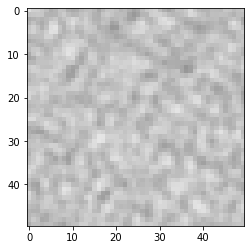

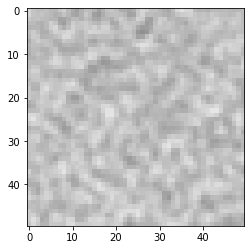

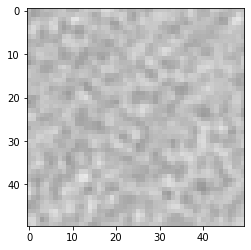

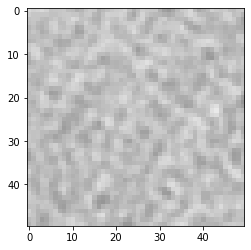

In [15]:
hn3d = HillNoise3D([random() for _ in range(32)])

img_w = 50
img_h = 50

for z in range(0, 40, 10):
    img = Image.new('RGBA', (img_w, img_h), (0, 0, 0, 0))
    pixels = img.load()
    for x in range(img_w):
        for y in range(img_h):
            h = hn3d.evaluate(x, y, z) * 127 + 128
            r = h
            g = h
            b = h
            pixels[x, y] = ( int(r), int(g), int(b), int(255) )
    plt.imshow(img)
    plt.show()

In [16]:
# https://blog.bruce-hill.com/media/hill-noise/hill_noise_3dshader.html
# https://blog.bruce-hill.com/hill-noise

# TAU = 2 * pi
TAU = 6.283185307179586476925286766559005768394338798750211641949
# PHI = GOLDEN_RATIO = (sqrt(5)+1)/2
PHI = 1.618033988749894848204586834365638117720309179805762862135
LOG_PHI = 0.481211825059603447497758913424368423135184334385660519660
SQRT5 = 2.236067977499789696409173668731276235440618359611525724270

class HillNoise3Dbis:
    GOLDEN_RATIO = (sqrt(5)+1)/2
    def __init__(self, sizes, random=random):
        self.sizes = sizes
        self.offsets = [random()*2*pi for _ in range(3*len(sizes))]
        self.sigma = sqrt(sum((a/2)**2 for a in self.sizes))

        # // Find the biggest fibonacci number F_n such that F_n < RESOLUTION
        # int n = int(log((float(RESOLUTION)-1.)*SQRT5 + .5)/LOG_PHI);
        # float float_n = float(n);
        # int dec = int(.5 + pow(PHI,float_n)/SQRT5); // F_n, using closed form Fibonacci
        # float float_dec = float(dec);
        # int inc = int(.5 + float_dec/PHI); // F_(n-1)

        # Find the biggest Fibonacci number fib_num such that fib_num < resolution
        fib_num = floor( log((len(self.sizes) - 1) * sqrt(5) + .5) / log(self.GOLDEN_RATIO) )
        self.dec = floor( .5 + (self.GOLDEN_RATIO**fib_num) / sqrt(5) )
        self.inc = floor( .5 + self.dec / self.GOLDEN_RATIO )

    def evaluate(self, x, y, z, normalize=True):
        # float noise = 0.;
        # int j = 0;
        # float sum_amplitudes = 0.;

        noise = 0
        j = 0
        sum_amplitudes = 0

        # for (int i=0; i<RESOLUTION; ++i) {
        for i in range(len(self.sizes)):

            # if (j >= dec) {
            #     j -= dec;
            # } else {
            #     j += inc;
            #     if (j >= RESOLUTION)
            #         j -= dec;
            # }

            if j >= self.dec:
                j -= self.dec
            else:
                j += self.inc
                if j >= len(self.sizes):
                    j -= self.dec

            # // Convert golden ratio sequence into polar coordinate unit vector
            # float phi = mod(float(i)*PHI,1.)*TAU;
            # float theta = acos(mix(-1.,1.,mod(float(j)*PHI,1.)));
        
            # Convert golden ratio sequence into polar coordinate unit vector
            phi = ((i * self.GOLDEN_RATIO) % 1) * 2*pi
            theta = acos(-1 + 2 * ((j*self.GOLDEN_RATIO) % 1))

            # // Make an orthonormal basis, where n1 is from polar phi/theta,
            # // n2 is roated 90 degrees along phi, and n3 is the cross product of the two
            # vec3 n1 = vec3(sin(phi)*cos(theta), sin(phi)*sin(theta), cos(phi));
            # vec3 n2 = vec3(sin(phi+TAU/4.)*cos(theta), sin(phi+TAU/4.)*sin(theta), cos(phi+TAU/4.));
            # vec3 n3 = cross(n1,n2);

            # Make an orthonormal basis, where n1 is from polar phi/theta,
            # n2 is roated 90 degrees along phi, and n3 is the
            # cross product of the two
            n1x,n1y,n1z = sin(phi)*cos(theta), sin(phi)*sin(theta), cos(phi)
            n2x,n2y,n2z = cos(phi)*cos(theta), cos(phi)*sin(theta), -sin(phi)

            # Cross product
            n3x,n3y,n3z = (n1y*n2z - n1z*n2y,
                           n1z*n2x - n1x*n2z,
                           n1x*n2y - n1y*n2x)

            # // Convert pos from x/y/z coordinates to n1/n2/n3 coordinates
            # float u = dot(n1, pos);
            # float v = dot(n2, pos);
            # float w = dot(n3, pos);

            # Convert pos from x/y/z coordinates to n1/n2/n3 coordinates
            u = n1x*x + n1y*y + n1z*z
            v = n2x*x + n2y*y + n2z*z
            w = n3x*x + n3y*y + n3z*z

            # // Pull the amplitude from the shuffled array index ("j"), not "i",
            # // otherwise neighboring unit vectors will have similar amplitudes!
            # float a = amplitudes[i];
            # sum_amplitudes += a;
            # //float a = pow(mod(float(i+1)*(PHI-1.), 1.), .3);

            # Pull the amplitude from the shuffled array index ("j"), not "i",
            # otherwise neighboring unit vectors will have similar amplitudes!
            size = self.sizes[j]
            sum_amplitudes += size
            
            # // Noise is the average of cosine of distance along each axis, shifted by offsets and scaled by amplitude.
            # noise += a*(cos(u/a + offsets[i].x) + cos(v/a + offsets[i].y) + cos(w/a + offsets[i].z))/3.;
            # if (i >= max_amplitude) {break;}

            # Noise is the average of cosine of distance along
            # each axis, shifted by offsets and scaled by amplitude.
            noise += size/3*(  cos(u/size + self.offsets[3*i])
                             + cos(v/size + self.offsets[3*i + 1])
                             + cos(w/size + self.offsets[3*i + 2]))

        # if (normalize) {
        #     return cdf(noise);
        # } else {
        #     return .5 + (noise/sum_amplitudes);
        # }

        if normalize:
            # Approximate normal CDF:
            noise /= 3 * self.sigma
            return (0.5 * (-1 if noise < 0 else 1) * sqrt(1 - exp(-2/pi * noise*noise)) + 0.5)            

        else:
             return .5 + (noise / sum_amplitudes);


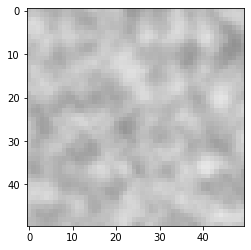

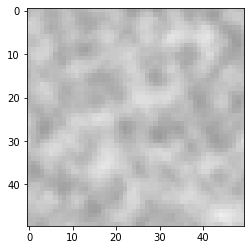

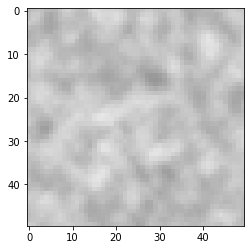

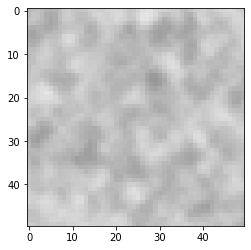

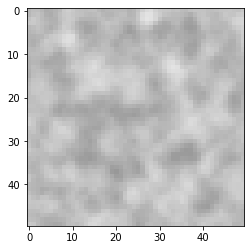

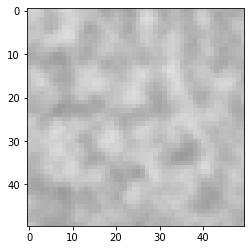

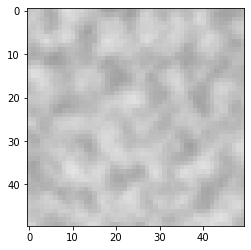

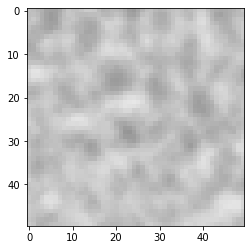

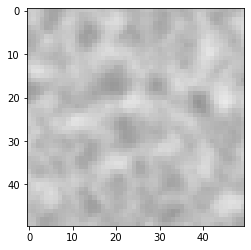

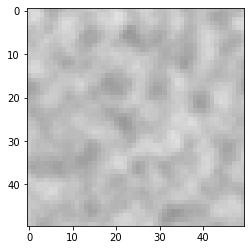

In [17]:
hn3d = HillNoise3Dbis([random() for _ in range(32)])

img_w = 50
img_h = 50

for z in range(0, 10, 1):
    img = Image.new('RGBA', (img_w, img_h), (0, 0, 0, 0))
    pixels = img.load()
    for x in range(img_w):
        for y in range(img_h):
            h = hn3d.evaluate(x / 2, y / 2, z) * 127 + 128
            r = h
            g = h
            b = h
            pixels[x, y] = ( int(r), int(g), int(b), int(255) )
    plt.imshow(img)
    plt.show()

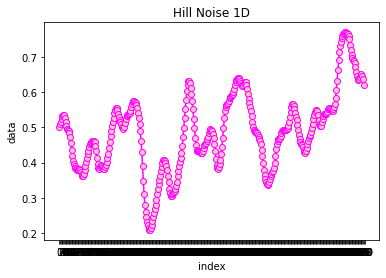

In [18]:
data = [hn3d.evaluate(i/10, 0, 0) for i in range(0, 400)]

plt.plot(data, color='magenta', marker='o',mfc='pink' )
plt.xticks(range(0,len(data)+1, 1))

plt.ylabel('data')
plt.xlabel('index')
plt.title("Hill Noise 1D")
plt.show()

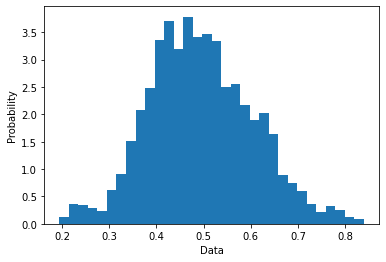

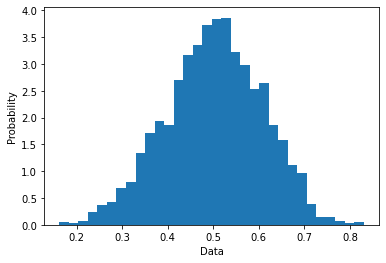

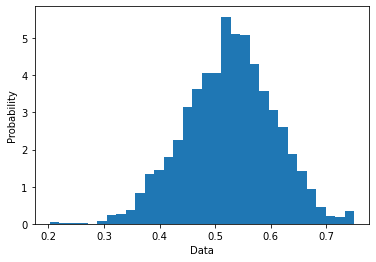

In [19]:
v = [ hn3d.evaluate(x/10, 0, 0) for x in range(0, 5000) ]

plt.hist(v, density=True, bins=32)
plt.ylabel('Probability')
plt.xlabel('Data')
plt.show()

v = [ hn3d.evaluate(0, y/10, 0) for y in range(0, 5000) ]

plt.hist(v, density=True, bins=32)
plt.ylabel('Probability')
plt.xlabel('Data')
plt.show()

v = [ hn3d.evaluate(0, 0, z/10) for z in range(0, 5000) ]

plt.hist(v, density=True, bins=32)
plt.ylabel('Probability')
plt.xlabel('Data')
plt.show()
